In [1]:
import sys
sys.path.append('/kaggle/input/alexnet/pytorch/improved-relu/1')
import torch
import torch.nn as nn
from torchvision import datasets
from improved.model import AlexNetImproved, init_params
from improved.data_transforms import prepreprocess, get_preprocess, get_train_augment, calc_mean_std
from improved.pca import pca
from improved.train import train
import matplotlib.pyplot as plt
from improved.eval import top1_k

In [2]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
train_dataset = datasets.CIFAR100(
    'datasets/cifar100', train=True, download=True, transform=prepreprocess)
mean, std = calc_mean_std(train_dataset)
print(f'Mean:\n{mean}')
print(f'Standard Deviation:\n{std}')
preprocess = get_preprocess(mean, std)

train_dataset = datasets.CIFAR100(
    'datasets/cifar100', train=True, transform=preprocess)
eigvals, eigvecs = pca(train_dataset)
train_augment = get_train_augment(eigvals, eigvecs, mean, std)

train_dataset = datasets.CIFAR100(
    'datasets/cifar100', train=True, transform=train_augment)

val_dataset = datasets.CIFAR100(
    'datasets/cifar100', train=False, transform=preprocess)
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [0.5, 0.5])

print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

100%|██████████| 169001437/169001437 [00:05<00:00, 29640155.64it/s]


Extracting datasets/cifar100/cifar-100-python.tar.gz to datasets/cifar100
Mean:
[0.5072646737098694, 0.4867367148399353, 0.4411051571369171]
Standard Deviation:
[0.2621012330055237, 0.2511281669139862, 0.2712865471839905]
Covar:
tensor([[1.0000, 0.8625, 0.7042],
        [0.8625, 0.9998, 0.8843],
        [0.7042, 0.8843, 1.0000]], device='cuda:0')
Eigen values (sqrt):
tensor([[0.2588],
        [0.5444],
        [1.6237]])
Eigen vectors:
tensor([[ 0.3872,  0.7312,  0.5616],
        [-0.7971, -0.0405,  0.6024],
        [ 0.4633, -0.6809,  0.5672]])
Number of classes: 100
Train samples: 50000
Validation samples: 5000
Test samples: 5000


In [4]:
model = AlexNetImproved(len(train_dataset.classes))
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    model = nn.DataParallel(model)
model.to(device)
# initialize parameters
init_params(model)
compiled_model = model
# if torch.cuda.is_available():
#     compiled_model = torch.compile(model)

In [5]:
costs, val_error_rates, learning_rates = train(
    compiled_model,
    train_dataset=train_dataset,
    cv_dataset=val_dataset,
    batch_size=128,
    num_epochs=100,
    initial_lr=0.01,
    num_workers=3,
    patience=10
)

Epoch 1/100, Cost: 4.207, Val Error: 82.98%, lr: 0.01, Time: 110s
Epoch 2/100, Cost: 3.635, Val Error: 73.70%, lr: 0.01, Time: 111s
Epoch 3/100, Cost: 3.331, Val Error: 69.04%, lr: 0.01, Time: 106s
Epoch 4/100, Cost: 3.105, Val Error: 63.80%, lr: 0.01, Time: 112s
Epoch 5/100, Cost: 2.900, Val Error: 60.66%, lr: 0.01, Time: 109s
Epoch 6/100, Cost: 2.777, Val Error: 59.82%, lr: 0.01, Time: 109s
Epoch 7/100, Cost: 2.645, Val Error: 57.54%, lr: 0.01, Time: 110s
Epoch 8/100, Cost: 2.533, Val Error: 54.80%, lr: 0.01, Time: 106s
Epoch 9/100, Cost: 2.459, Val Error: 54.42%, lr: 0.01, Time: 106s
Epoch 10/100, Cost: 2.367, Val Error: 51.56%, lr: 0.01, Time: 115s
Epoch 11/100, Cost: 2.297, Val Error: 49.74%, lr: 0.01, Time: 110s
Epoch 12/100, Cost: 2.237, Val Error: 49.08%, lr: 0.01, Time: 115s
Epoch 13/100, Cost: 2.168, Val Error: 46.94%, lr: 0.01, Time: 109s
Epoch 14/100, Cost: 2.106, Val Error: 44.28%, lr: 0.01, Time: 111s
Epoch 15/100, Cost: 2.065, Val Error: 44.02%, lr: 0.01, Time: 107s
Epoc

In [6]:
torch.save(model.state_dict(), 'improved_cifar100.model.pt')
torch.save(preprocess, 'improved_cifar100.preprocess.pt')
torch.save(train_augment, 'improved_cifar100.train_augment.pt')

In [7]:
test_top1, test_top5 = top1_k(compiled_model, test_dataset, k=5)
print(f'Test Top 1: {test_top1}')
print(f'Test Top 5: {test_top5}')

val_top1, val_top5 = top1_k(compiled_model, val_dataset, k=5)
print(f'Val Top 1: {val_top1}')
print(f'Val Top 5: {val_top5}')

train_eval_dataset = datasets.CIFAR100(
    'datasets/cifar100', train=True, transform=preprocess)
train_top1, train_top5 = top1_k(compiled_model, train_eval_dataset, k=5)
print(f'Train Top 1: {train_top1}')
print(f'Train Top 5: {train_top5}')

Test Top 1: 0.7214
Test Top 5: 0.9266
Val Top 1: 0.7104
Val Top 5: 0.9182
Train Top 1: 0.9624
Train Top 5: 0.99918


Text(0.5, 1.0, 'Costs')

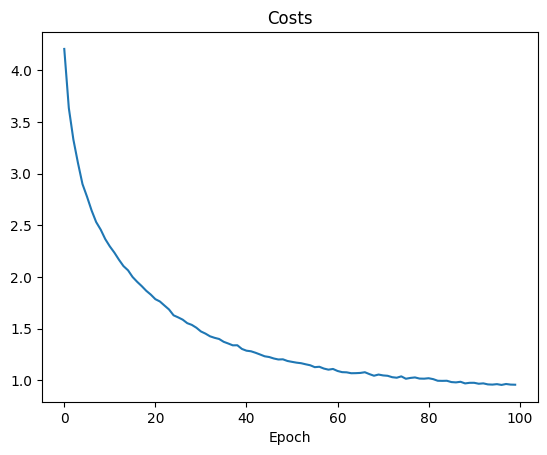

In [8]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.title('Costs')

Text(0.5, 1.0, 'Validation Error Rates')

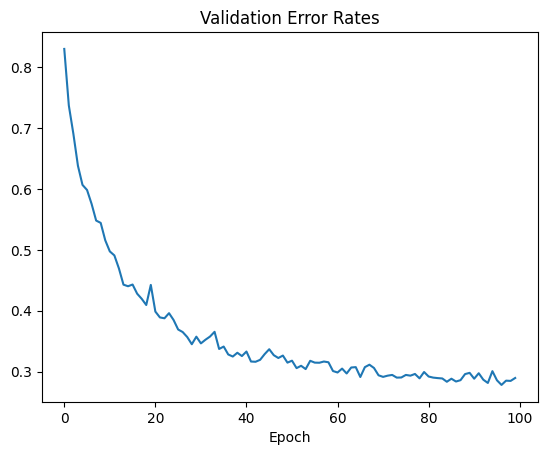

In [9]:
plt.plot(val_error_rates)
plt.xlabel("Epoch")
plt.title('Validation Error Rates')

Text(0.5, 1.0, 'Learning Rates')

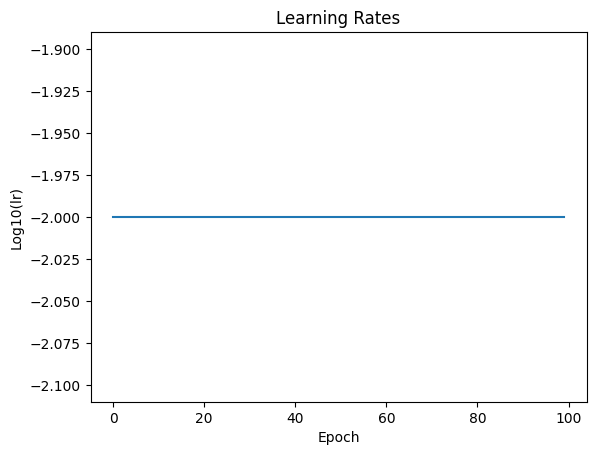

In [10]:
import math

plt.plot([math.log10(lr) for lr in learning_rates])
plt.ylabel("Log10(lr)")
plt.xlabel("Epoch")
plt.title('Learning Rates')